In [1]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.applications.vgg19 import (
    VGG19, 
    preprocess_input, 
    decode_predictions
)

Using TensorFlow backend.


In [2]:
# Load the VGG19 model
# https://keras.io/applications/#VGG19
model = VGG19(include_top=True, weights='imagenet')

In [3]:
# Define default image size for VGG19
image_size = (224, 224)

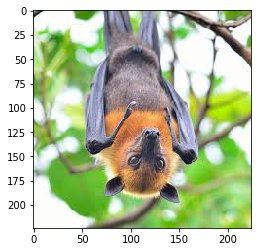

In [4]:
# Load the image and resize to default image size
image_path = os.path.join("..", "Images", "fox-bat.jpg")
img = image.load_img(image_path, target_size=image_size)
plt.imshow(img)

In [5]:
# Preprocess image for model prediction
# This step handles scaling and normalization for VGG19
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Predicted: [[('n01558993', 'robin', 0.25857633), ('n01843065', 'jacamar', 0.18684526), ('n02492660', 'howler_monkey', 0.15744697)]]


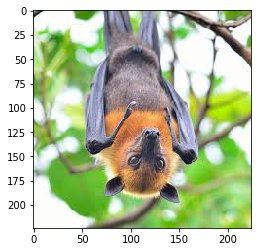

In [6]:
# Make predictions
predictions = model.predict(x)
print('Predicted:', decode_predictions(predictions, top=3))
plt.imshow(img)

In [8]:
np.argmax(predictions[0])

15

In [11]:
# Refernced from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb
from keras import backend as K

# This is the "flying fox bat" entry in the prediction vector
bat_output = model.output[:, 15]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(bat_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

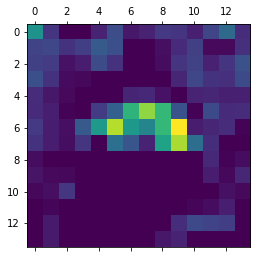

In [12]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [13]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(image_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('/Users/Paul-DS/Downloads/bat_cam.jpg', superimposed_img)

True

In [8]:
# Refactor above steps into reusable function
def predict(image_path):
    """Use VGG19 to label image"""
    img = image.load_img(image_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    predictions = model.predict(x)
    plt.imshow(img)
    print('Predicted:', decode_predictions(predictions, top=3))

Predicted: [[('n04350905', 'suit', 0.5640449), ('n02883205', 'bow_tie', 0.2810115), ('n04591157', 'Windsor_tie', 0.033715446)]]


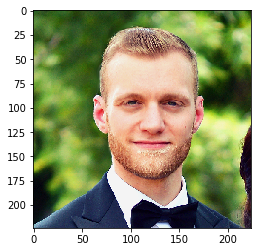

In [9]:
image_path = os.path.join("..", "Images", "test.jpg")
predict(image_path)